In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from xgboost import XGBRegressor as xgb
import os
import copy

In [29]:
train = pd.read_csv('data.csv')

dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)

In [30]:
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [31]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [32]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [33]:
rf_train = copy.copy(train)

# EDA

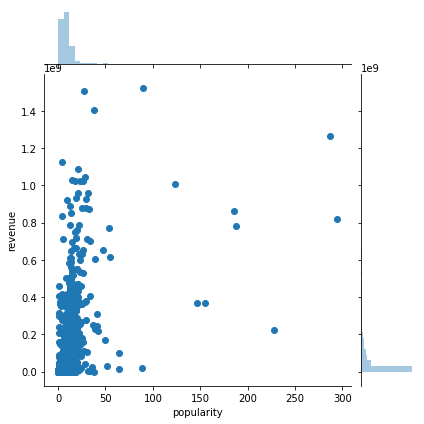

In [34]:
sns.jointplot(x=rf_train["popularity"], y=rf_train["revenue"], kind='scatter')

In [35]:
rf_train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

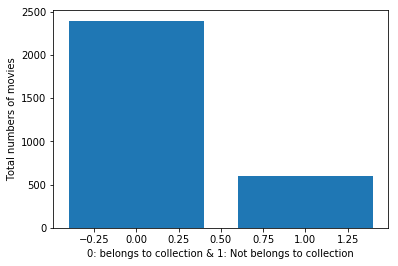

In [36]:
y = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()
plt.bar(y.index, list(y))
plt.xlabel('0: belongs to collection & 1: Not belongs to collection')
plt.ylabel('Total numbers of movies')
plt.show()

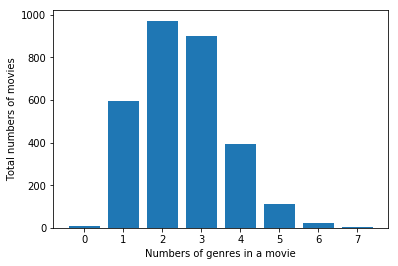

In [37]:
x = train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()
plt.bar(x.index, list(x))
plt.xlabel('Numbers of genres in a movie')
plt.ylabel('Total numbers of movies')
plt.show()

In [38]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
flat_list = [item for sublist in list_of_genres for item in sublist]
unique_genres = list(set(flat_list))
genres_movies = {}
for item in flat_list:
    if item in genres_movies.keys():
        genres_movies[item] += 1
    else:
        genres_movies[item] = 1

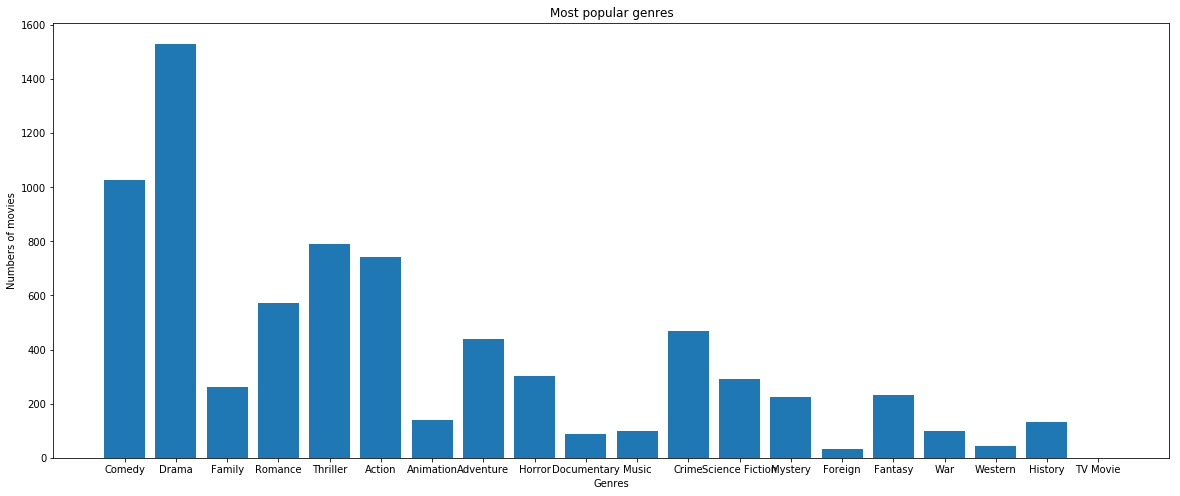

In [39]:
plt.figure(figsize=(20,8))
plt.bar(genres_movies.keys(), genres_movies.values())
plt.xlabel('Genres')
plt.ylabel('Numbers of movies')
plt.title('Most popular genres')
plt.show()

In [40]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
flat_list_of_companies = [item for sublist in list_of_companies for item in sublist]

companies_movies = {}
for item in flat_list_of_companies:
    if item in companies_movies.keys():
        companies_movies[item] += 1
    else:
        companies_movies[item] = 1

In [41]:
'''
    Most popular producers
'''
company_movies = pd.DataFrame(companies_movies.keys(), columns=['Name_of_company'])
company_movies['Total movies'] = companies_movies.values() 

company_movies.sort_values('Total movies', ascending=[0])[:20]

,Name_of_company,Total movies
111,Warner Bros.,202
56,Universal Pictures,188
0,Paramount Pictures,161
12,Twentieth Century Fox Film Corporation,138
133,Columbia Pictures,91
2,Metro-Goldwyn-Mayer (MGM),84
43,New Line Cinema,75
174,Touchstone Pictures,63
3,Walt Disney Pictures,62
113,Columbia Pictures Corporation,61


## Data preparation 

In [42]:
rf_train['release_date'] = pd.to_datetime(rf_train['release_date'])
rf_train['year'], rf_train['month'] = rf_train['release_date'].dt.year, rf_train['release_date'].dt.month

In [43]:
from sklearn.preprocessing import LabelEncoder
le_language_train = LabelEncoder()
#Train
rf_train['language_encoded'] = le_language_train.fit_transform(rf_train.original_language)

rf_train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,status,tagline,title,Keywords,cast,crew,revenue,year,month,language_encoded
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2015,2,7
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,2004,8,7
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,2014,10,7
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,2012,3,13
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,2009,2,18


In [44]:
rf_train.dtypes

id                                int64
belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
Keywords                         object
cast                             object
crew                             object
revenue                           int64
year                              int64
month                             int64


In [45]:
#rf_train[['id','budget','popularity','runtime','revenue']]
rf_train.drop(['belongs_to_collection','genres','homepage','imdb_id','original_language','original_title',
              'overview','poster_path','production_companies','production_countries','release_date',
              'spoken_languages','status','tagline','title','Keywords','cast','crew'], axis=1, inplace=True)

rf_train.head()

,id,budget,popularity,runtime,revenue,year,month,language_encoded
0,1,14000000,6.575393,93.0,12314651,2015,2,7
1,2,40000000,8.248895,113.0,95149435,2004,8,7
2,3,3300000,64.299990,105.0,13092000,2014,10,7
3,4,1200000,3.174936,122.0,16000000,2012,3,13
4,5,0,1.148070,118.0,3923970,2009,2,18


Drop Training Data NAs

In [46]:
rf_train.isna().sum()

id                  0
budget              0
popularity          0
runtime             2
revenue             0
year                0
month               0
language_encoded    0
dtype: int64

In [47]:
#Lets fill with Mean
mean_runtime=rf_train.iloc[:,3]
mean_runtime.head()

0     93.0
1    113.0
2    105.0
3    122.0
4    118.0
Name: runtime, dtype: float64

Fill NAs with Mean

In [48]:
mean_runtime.mean()

107.85657104736491

In [49]:
rf_train=rf_train.fillna(mean_runtime.mean())

In [50]:
rf_train.isna().sum()

id                  0
budget              0
popularity          0
runtime             0
revenue             0
year                0
month               0
language_encoded    0
dtype: int64

In [51]:
# comparing sizes of data frames 
print("Old data frame length:", len(train), "\nNew data frame length:",  
       len(rf_train), "\nNumber of rows with at least 1 NA value: ", 
       (len(train)-len(rf_train))) 

Old data frame length: 3000 
New data frame length: 3000 
Number of rows with at least 1 NA value:  0


In [52]:
rf_train.dtypes

id                    int64
budget                int64
popularity          float64
runtime             float64
revenue               int64
year                  int64
month                 int64
language_encoded      int64
dtype: object

# ML Model without addition of any features

### Random forest

In [59]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = rf_train['revenue']
x_train = rf_train.drop(['revenue'], axis=1).values 


X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Create Decision Tree with max_depth = 6
decision_tree = DecisionTreeRegressor(max_depth = 6)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [60]:
# Predicting results for test dataset
pred = decision_tree.predict(X_test)
print('Mean squared log error: {}'.format(np.mean(mean_squared_log_error(y_test, pred))))
print('R-square: {}'.format(r2_score(y_test, pred)))

Mean squared log error: 6.413062482197325
R-square: 0.29959802240610256


In [64]:
'''
    XGB
'''

import xgboost
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7,
                 gamma=0,                 
                 learning_rate=0.001,
                 max_depth=5,
                 min_child_weight=0.5,
                 n_estimators=5000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.4,
                 seed=42)
xgb_model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.7, gamma=0, importance_type='gain',
             learning_rate=0.001, max_delta_step=0, max_depth=5,
             min_child_weight=0.5, missing=None, n_estimators=5000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             silent=True, subsample=0.4)

In [65]:
pred = best_xgb_model.predict(X_test)

In [67]:
print('Mean squared log error: {}'.format(np.mean(mean_squared_log_error(y_test, abs(pred)))))
print('R-square: {}'.format(r2_score(y_test, pred)))

Mean squared log error: 6.246661887504426
R-square: 0.6824951589870408


In [68]:
'''
    Feature importance
'''
features_importance = pd.DataFrame(rf_train.drop(['revenue'], axis=1).columns, columns=['Features']) 
features_importance['Importance'] = xgb_model.feature_importances_

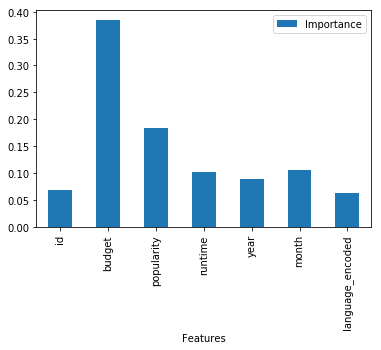

In [69]:
features_importance.plot.bar(y ='Importance', x='Features')

# New Features Addition

In [70]:
# Genres
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)

In [71]:
# Collection 
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)

In [72]:
# Spoken language
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(10)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)

In [73]:
# Homepage
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

In [74]:
rf_train = copy.copy(train)
rf_train.drop(['id','homepage','imdb_id','original_language','original_title',
              'overview','poster_path','production_companies','production_countries','release_date',
              'spoken_languages','status','tagline','title','Keywords','cast','crew','all_genres', 'all_languages'], axis=1, inplace=True)

rf_train.head()

,budget,popularity,runtime,revenue,num_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,...,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,has_homepage
0,14000000,6.575393,93.0,12314651,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,40000000,8.248895,113.0,95149435,4,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3300000,64.299990,105.0,13092000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1200000,3.174936,122.0,16000000,2,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
4,0,1.148070,118.0,3923970,2,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,has_homepage
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,0,0,0,0,0,0,0,0,1,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,0,0,0,0,0,0,0,0,1,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",...,0,0,0,0,0,0,0,0,1,1
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},...,0,0,0,0,0,0,0,1,1,1
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},...,0,0,0,0,0,0,0,0,1,0


In [76]:
rf_train.isna().sum()

budget                   0
popularity               0
runtime                  2
revenue                  0
num_genres               0
genre_Drama              0
genre_Comedy             0
genre_Thriller           0
genre_Action             0
genre_Romance            0
genre_Crime              0
genre_Adventure          0
genre_Horror             0
genre_Science Fiction    0
genre_Family             0
has_collection           0
num_languages            0
language_English         0
language_Français        0
language_Español         0
language_Deutsch         0
language_Pусский         0
language_Italiano        0
language_日本語             0
language_普通话             0
language_हिन्दी          0
language_                0
has_homepage             0
dtype: int64

In [77]:
#Lets fill with Mean
mean_runtime=rf_train.iloc[:,3]
mean_runtime.head()

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
Name: revenue, dtype: int64

In [78]:
mean_runtime.mean()

66725851.88866667

In [79]:
rf_train=rf_train.fillna(mean_runtime.mean())

In [80]:
rf_train.isna().sum()

budget                   0
popularity               0
runtime                  0
revenue                  0
num_genres               0
genre_Drama              0
genre_Comedy             0
genre_Thriller           0
genre_Action             0
genre_Romance            0
genre_Crime              0
genre_Adventure          0
genre_Horror             0
genre_Science Fiction    0
genre_Family             0
has_collection           0
num_languages            0
language_English         0
language_Français        0
language_Español         0
language_Deutsch         0
language_Pусский         0
language_Italiano        0
language_日本語             0
language_普通话             0
language_हिन्दी          0
language_                0
has_homepage             0
dtype: int64

In [81]:
# comparing sizes of data frames 
print("Old data frame length:", len(train), "\nNew data frame length:",  
       len(rf_train), "\nNumber of rows with at least 1 NA value: ", 
       (len(train)-len(rf_train))) 

Old data frame length: 3000 
New data frame length: 3000 
Number of rows with at least 1 NA value:  0


In [83]:
'''
    XGB
'''
import xgboost
y_train = rf_train['revenue']
x_train = rf_train.drop(['revenue'], axis=1).values 
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

xgb_model = xgboost.XGBRegressor(colsample_bytree=1,                 
                 learning_rate=0.0001,
                 max_depth=6,
                 min_child_weight=0.75,
                 n_estimators=30000,                                                                    
                 subsample=0.4,
                 seed=42)
xgb_model.fit(X_train,y_train)

pred = xgb_model.predict(X_test)
print('Mean squared log error: {}'.format(np.sqrt(mean_squared_log_error(y_test, abs(pred)))))
print('R-squared: {}'.format(r2_score(y_test, pred)))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean squared log error: 2.445807640831329
R-squared: 0.7225158079034946


In [97]:
pred = xgb_model.predict(X_train)
r2_score(y_train, abs(pred))

0.8591122684515049

In [84]:
'''
    Feature importance
'''
features_importance = pd.DataFrame(rf_train.drop(['revenue'], axis=1).columns, columns=['Features']) 
features_importance['Importance'] = xgb_model.feature_importances_

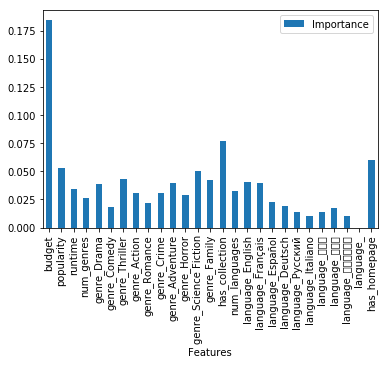

In [85]:
features_importance.plot.bar(y ='Importance', x='Features')